# Task 1

---

## Web scraping and analysis

We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from bs4 import BeautifulSoup
from wordcloud import WordCloud 

plt.style.use('ggplot')

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 4
page_size = 100

reviews = []
rating = []
category = []
df = pd.DataFrame()
# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
        
    for para1 in parsed_content.find_all("div", {"class" : "review-stats"}):
        for para2 in para1.find_all('td',{'class' : 'review-value'}):
            rating.append(para2.get_text())
        recomend = rating[-1]
        rating = rating[:-1]
        
        for para3 in para1.find_all('td',{'class' : 'review-rating-stars stars'}):
            para4 = len(para3.find_all('span', {'class' : 'star fill'}))
            rating.append(para4)
        rating.append(recomend)
        
        for para5 in para1.find_all('td',{'class' : 'review-rating-header'}):
            category.append(para5.get_text())
            
        data_dict = pd.DataFrame([rating], columns=category)
        df = pd.concat([df, data_dict], ignore_index=True).reset_index(drop=True)
        
        rating = []
        category = []
        
    print(f"   ---> {len(reviews)} total reviews")
    
df['reviews'] = reviews
df.drop_duplicates().reset_index(inplace=True, drop=True)

'\nbase_url = "https://www.airlinequality.com/airline-reviews/british-airways"\npages = 4\npage_size = 100\n\nreviews = []\nrating = []\ncategory = []\ndf = pd.DataFrame()\n# for i in range(1, pages + 1):\nfor i in range(1, pages + 1):\n\n    print(f"Scraping page {i}")\n\n    # Create URL to collect links from paginated data\n    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"\n\n    # Collect HTML data from this page\n    response = requests.get(url)\n\n    # Parse content\n    content = response.content\n    parsed_content = BeautifulSoup(content, \'html.parser\')\n    for para in parsed_content.find_all("div", {"class": "text_content"}):\n        reviews.append(para.get_text())\n        \n    for para1 in parsed_content.find_all("div", {"class" : "review-stats"}):\n        for para2 in para1.find_all(\'td\',{\'class\' : \'review-value\'}):\n            rating.append(para2.get_text())\n        recomend = rating[-1]\n        rating = rating[:-1]\n        \n

In [3]:
df

In [4]:
df.to_csv("BA_reviews.csv", index = False)

## Data Cleansing

In [5]:
df = pd.read_csv('BA_reviews.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Aircraft                204 non-null    object 
 1   Type Of Traveller       399 non-null    object 
 2   Seat Type               400 non-null    object 
 3   Route                   398 non-null    object 
 4   Date Flown              400 non-null    object 
 5   Seat Comfort            345 non-null    float64
 6   Cabin Staff Service     344 non-null    float64
 7   Food & Beverages        309 non-null    float64
 8   Inflight Entertainment  195 non-null    float64
 9   Ground Service          360 non-null    float64
 10  Value For Money         400 non-null    int64  
 11  Recommended             400 non-null    object 
 12  Wifi & Connectivity     120 non-null    float64
 13  reviews                 400 non-null    object 
dtypes: float64(6), int64(1), object(7)
memory 

In [7]:
remove_text = ['✅ Trip Verified', 'Not Verified', '|']

for i in range(len(df['reviews'])):
    for j in remove_text:
        if j in df['reviews'][i]:
            df['reviews'] = df['reviews'].str.replace(j,'').apply(lambda x: x.strip().lower())

C:\Users\Kobiy\AppData\Local\Temp\ipykernel_7292\35993523.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['reviews'] = df['reviews'].str.replace(j,'').apply(lambda x: x.strip().lower())


In [8]:
df[df.columns[5:10]] = df[df.columns[5:10]].transform(lambda x: x.fillna(x.mean())).round()

In [9]:
df['Date Flown'] = pd.to_datetime(df['Date Flown'])
df2 = df[df['Date Flown'].dt.year >= 2021]

I have looked at the data and I decided to use the data from 2021-2022 because a lot of things have changed since the new normal and airlines are the most affected.

In [10]:
df2['Seat Type'].value_counts()

Economy Class      137
Business Class     113
Premium Economy     22
First Class          3
Name: Seat Type, dtype: int64

## Reviews Analysis

In [40]:
df2[df2.columns[:11]].groupby(['Seat Type']).mean().sort_values('Value For Money', ascending=False).round(1)

C:\Users\Kobiy\AppData\Local\Temp\ipykernel_7292\2713412376.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2[df2.columns[:11]].groupby(['Seat Type']).mean().sort_values('Value For Money', ascending=False).round(1)


,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money
Seat Type,,,,,,
First Class,3.7,3.7,2.3,3.0,3.0,3.0
Premium Economy,3.1,3.1,3.0,3.2,2.9,2.9
Business Class,3.1,3.4,3.0,2.9,2.9,2.7
Economy Class,2.6,3.0,2.5,2.9,2.2,2.1


economy class scores significantly lower on each rating

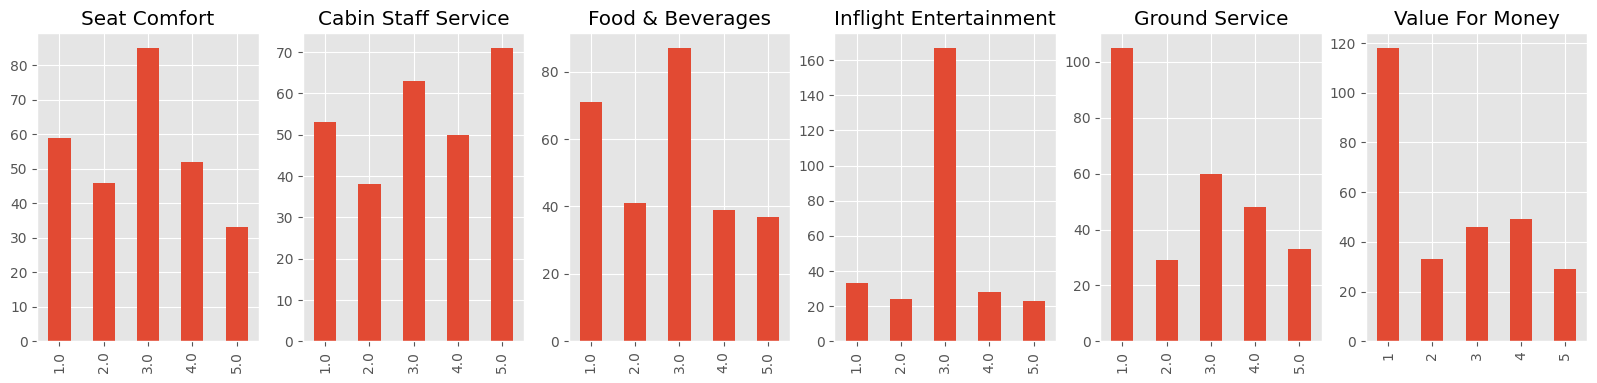

In [12]:
fig, axs = plt.subplots(1, 6, figsize=(20, 4))

for i, j in enumerate(df2.columns[5:11]):
    df2[j].value_counts().sort_index().plot(kind='bar', ax = axs[i])
    axs[i].set_title(j)
plt.show()

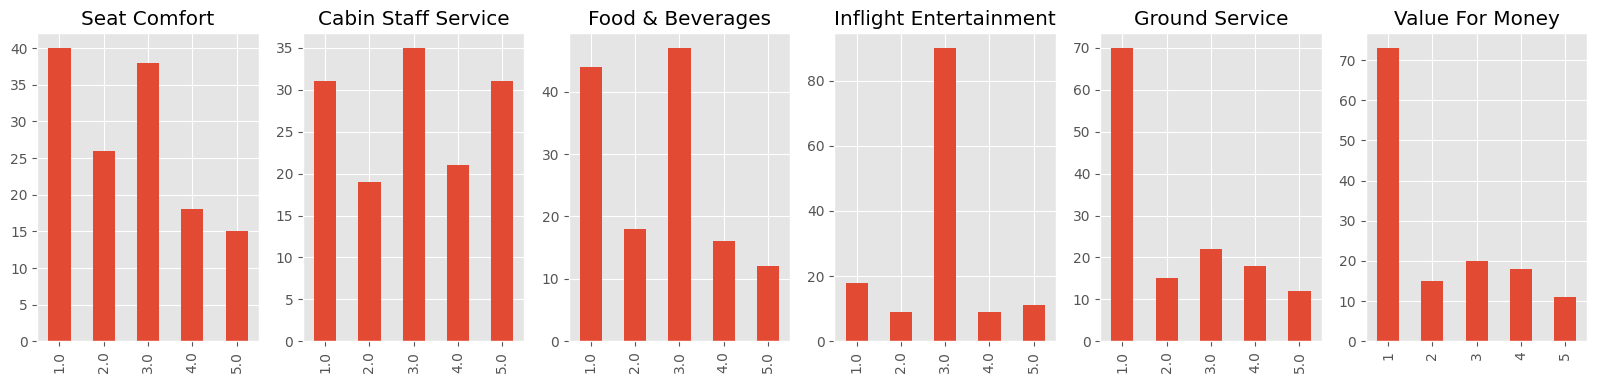

In [13]:
eco = df2[df2['Seat Type'] == 'Economy Class']

fig, axs = plt.subplots(1, 6, figsize=(20, 4))

for i, j in enumerate(eco.columns[5:11]):
    eco[j].value_counts().sort_index().plot(kind='bar', ax = axs[i])
    axs[i].set_title(j)
plt.show()

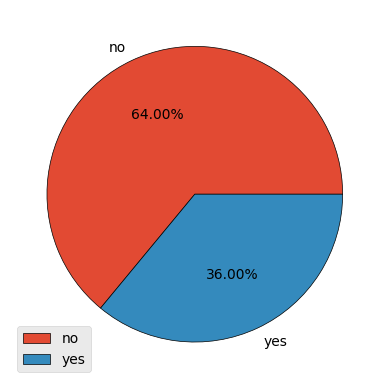

In [51]:
piec = df2.groupby('Recommended')['reviews'].count().reset_index()
plt.pie(piec['reviews'], labels = piec['Recommended'], autopct='%.2f%%', wedgeprops={"edgecolor":"k"});
plt.legend(labels=piec['Recommended']);

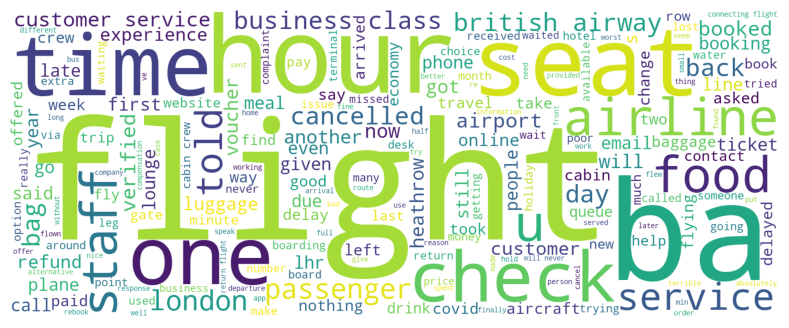

In [16]:
norec = df2[df2['Recommended']=='no']['reviews']

review_word = []

for i in norec:
    a = i.split(' ')
    for x in a:
        review_word.append(x)
        
unique_string = (" ").join(review_word)

plt.figure(figsize=(12, 4))
wc = WordCloud(width = 1500, height = 600, background_color = 'white').generate(unique_string)
plt.imshow(wc)
plt.axis("off");

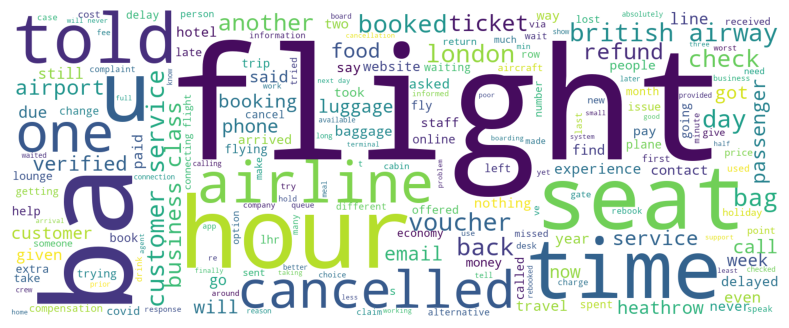

In [98]:
val1 = df2[df2['Value For Money']==1]['reviews']

review_word = []

for i in val1:
    a = i.split(' ')
    for x in a:
        review_word.append(x)
        
unique_string = (" ").join(review_word)

plt.figure(figsize=(12, 4))
wc = WordCloud(width = 1500, height = 600, background_color = 'white').generate(unique_string)
plt.imshow(wc)
plt.axis("off");

In [106]:
# pd.set_option('display.max_colwidth', None)
val1[val1.apply(lambda x: len(x) < 600)]

5                                                                                                                                                                                                                                                                                            british airways is late, their website is atrocious, and they wouldn't let me check-in until 24 hours before the flight. i have been trying for 6 hours to check in through their website, and/or find a real person to speak with. customer service had such a thick accent i didn't think they were speaking english.
9                                                                                                                                                                                                                                                                                                    not verified  worst experience ever. outbound flight was cancelled and i was not notified. i was rebooked on a